In [1]:
# %%
import os
import jax

# 设置环境变量
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '0'

import netket as nk
import jax
print("启用分片模式：", nk.config.netket_experimental_sharding)
print("可用设备：", jax.devices())


启用分片模式： False
可用设备： [CudaDevice(id=0)]


In [2]:
# %%
import os
import logging
import sys
import jax
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import netket.nn as nknn
import flax
import flax.linen as nn
import jax.numpy as jnp
import math
from math import pi
from functools import partial
from netket.nn import log_cosh
from einops import rearrange
from netket.utils.group.planar import rotation, reflection_group, D, glide, glide_group
from netket.utils.group import PointGroup, Identity, PermutationGroup
from netket.operator.spin import sigmax, sigmay, sigmaz
from netket.optimizer.qgt import QGTJacobianPyTree, QGTJacobianDense, QGTOnTheFly
from netket.operator import AbstractOperator
from netket.vqs import VariationalState
from scipy import sparse as _sparse
from netket.utils.types import DType as _DType
from netket.hilbert import DiscreteHilbert as _DiscreteHilbert
from netket.operator import LocalOperator as _LocalOperator
from tqdm.notebook import tqdm
from jax import tree

In [3]:
import numpy as np
import jax.numpy as jnp
from flax import linen as nn
from jax.nn.initializers import zeros, lecun_normal
from netket.utils import HashableArray
from netket.jax import logsumexp_cplx
from netket.nn.activation import reim_selu
from netket.nn.symmetric_linear import DenseSymmMatrix, DenseEquivariantIrrep

# 默认GCNN初始化器
default_gcnn_initializer = lecun_normal(in_axis=1, out_axis=0)

def identity(x):
    return x

class GCNN_Parity_Irrep(nn.Module):
    """基于不可约表示实现的带宇称对称性的GCNN"""
    
    symmetries: HashableArray  # 对称操作数组
    irreps: tuple  # 不可约表示矩阵列表
    layers: int  # 层数 
    features: tuple  # 每层特征数
    characters: HashableArray  # 指定所需对称表示的字符
    parity: int = 1  # 宇称值
    param_dtype: any = np.complex128  # 参数数据类型
    input_mask: any = None  # 输入掩码
    equal_amplitudes: bool = False  # 是否强制等幅
    use_bias: bool = True  # 是否使用偏置

    def setup(self):
        # 第一层：对称化线性变换
        self.dense_symm = DenseSymmMatrix(
            symmetries=self.symmetries,
            features=self.features[0],
            param_dtype=self.param_dtype,
            use_bias=self.use_bias,
            kernel_init=default_gcnn_initializer,
            bias_init=zeros,
            mask=self.input_mask,
        )

        # 使用元组推导式创建固定数量的层
        # Flax要求层必须是模块属性，而不是列表项
        self.equivariant_layers = tuple(
            DenseEquivariantIrrep(
                irreps=self.irreps,
                features=self.features[layer + 1],
                use_bias=self.use_bias,
                param_dtype=self.param_dtype,
                kernel_init=default_gcnn_initializer,
                bias_init=zeros,
            )
            for layer in range(self.layers - 1)
        )
        
        self.equivariant_layers_flip = tuple(
            DenseEquivariantIrrep(
                irreps=self.irreps,
                features=self.features[layer + 1],
                use_bias=self.use_bias,
                param_dtype=self.param_dtype,
                kernel_init=default_gcnn_initializer,
                bias_init=zeros,
            )
            for layer in range(self.layers - 1)
        )

    @nn.compact
    def __call__(self, x):
        if x.ndim < 3:
            x = jnp.expand_dims(x, -2)  # 添加特征维度

        # 处理原始输入和翻转输入
        x_flip = self.dense_symm(-1 * x)
        x = self.dense_symm(x)

        for layer in range(self.layers - 1):
            x = reim_selu(x)
            x_flip = reim_selu(x_flip)

            # 混合原始和翻转路径
            x_new = (
                self.equivariant_layers[layer](x)
                + self.equivariant_layers_flip[layer](x_flip)
            ) / np.sqrt(2)
            x_flip = (
                self.equivariant_layers[layer](x_flip)
                + self.equivariant_layers_flip[layer](x)
            ) / np.sqrt(2)
            x = jnp.array(x_new, copy=True)

        # 连接原始和翻转路径的输出
        x = jnp.concatenate((x, x_flip), -1)

        # 构建宇称为1的字符
        par_chars = jnp.expand_dims(
            jnp.concatenate(
                (jnp.array(self.characters), jnp.array(self.characters)), 0
            ),
            (0, 1),
        )

        # 应用复值logsumexp
        x = logsumexp_cplx(x, axis=(-2, -1), b=par_chars)

        return x


def create_gcnn(symmetries, layers, features, mask=None, characters=None):
    """创建GCNN模型的简化函数"""
    
    # 处理特征参数
    if isinstance(features, int):
        features = (features,) * layers
    
    # 处理字符参数
    if characters is None:
        characters = HashableArray(np.ones(len(np.asarray(symmetries))))
    else:
        characters = HashableArray(characters)
    
    # 获取不可约表示
    sym = HashableArray(np.asarray(symmetries))
    irreps = tuple(HashableArray(irrep) for irrep in symmetries.irrep_matrices())
    
    # 处理掩码
    input_mask = HashableArray(mask) if mask is not None else None
    
    # 创建和返回模型
    return GCNN_Parity_Irrep(
        symmetries=sym,
        irreps=irreps,
        layers=layers,
        features=features,
        characters=characters,
        parity=1,
        param_dtype=np.complex128,
        input_mask=input_mask,
        equal_amplitudes=False,
    )


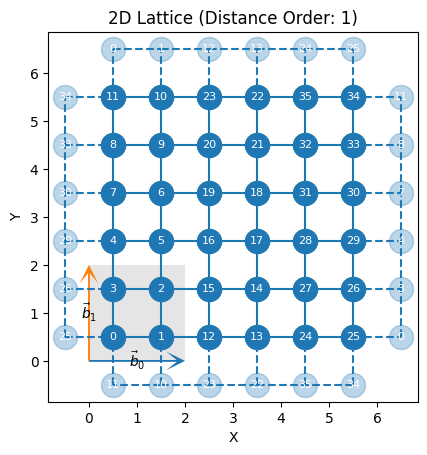

2025-04-15 11:20:13.442778: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.
2025-04-15 11:20:13.442819: W external/xla/xla/service/gpu/ir_emitter_unnested.cc:1171] Unable to parse backend config for custom call: Could not convert JSON string to proto: : Root element must be a message.
Fall back to parse the raw backend config str.


In [4]:
# 设置模型和哈密顿参数
N_features = 4
N_layers = 4
J1 = 0.8
J2 = 1.0
Q = 1.0 - J2
Lx = 3
Ly = 3

# 自定义边
custom_edges = [
    (0, 1, [1.0, 0.0], 0),
    (1, 0, [1.0, 0.0], 0),
    (1, 2, [0.0, 1.0], 0),
    (2, 1, [0.0, 1.0], 0),
    (3, 2, [1.0, 0.0], 0),
    (2, 3, [1.0, 0.0], 0),
    (0, 3, [0.0, 1.0], 0),
    (3, 0, [0.0, 1.0], 0),
    (2, 0, [1.0, -1.0], 1),
    (3, 1, [1.0, 1.0], 1),
]

# 创建晶格
lattice = nk.graph.Lattice(
    basis_vectors=[[2.0, 0.0], [0.0, 2.0]],
    extent=(Lx, Ly),
    site_offsets=[[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]],
    custom_edges=custom_edges,
    pbc=[True, True]
)

# 可视化晶格
lattice.draw()

# %%
# Hilbert空间定义
hilbert = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 自旋-1/2矩阵
sigmax = jnp.array([[0, 0.5], [0.5, 0]])
sigmay = jnp.array([[0, -0.5j], [0.5j, 0]])
sigmaz = jnp.array([[0.5, 0], [0, -0.5]])
unitm = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# 自旋-自旋相互作用
sxsx = np.kron(sigmax, sigmax)
sysy = np.kron(sigmay, sigmay)
szsz = np.kron(sigmaz, sigmaz)
umum = np.kron(unitm, unitm)
SiSj = sxsx + sysy + szsz

# 定义(Si·Sj - 1/4)算符
ProjOp = jnp.array(SiSj) - 0.25 * jnp.array(umum)
ProjOp2 = jnp.kron(ProjOp, ProjOp)

# 构建J1-J2部分的哈密顿量
bond_operator = [
    (J1 * SiSj).tolist(),
    (J2 * SiSj).tolist(),
]
bond_color = [0, 1]

# 创建图哈密顿量 - 不包含Q项
H_J = nk.operator.GraphOperator(hilbert, graph=lattice, bond_ops=bond_operator, bond_ops_colors=bond_color)

# 创建Q项哈密顿量
H_Q = nk.operator.LocalOperator(hilbert, dtype=jnp.complex128)

# 获取晶格尺寸
Lx, Ly = lattice.extent[0], lattice.extent[1]

# 遍历所有单元格
for x in range(Lx):
    for y in range(Ly):
        # 计算当前单元格的基本索引
        base = 4 * (y + x * Ly)
        
        # 当前单元格内的四个格点
        site0 = base      # 左下角 (0.5, 0.5)
        site1 = base + 1  # 右下角 (1.5, 0.5)
        site2 = base + 2  # 右上角 (1.5, 1.5)
        site3 = base + 3  # 左上角 (0.5, 1.5)
        
        # 找到相邻单元格（考虑周期性边界条件）
        right_x = (x + 1) % Lx
        right_base = 4 * (y + right_x * Ly)
        
        left_x = (x - 1 + Lx) % Lx
        left_base = 4 * (y + left_x * Ly)
        
        up_y = (y + 1) % Ly
        up_base = 4 * (up_y + x * Ly)
        
        down_y = (y - 1 + Ly) % Ly
        down_base = 4 * (down_y + x * Ly)
        
        # 1. 单元格内部的水平方向plaquette
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site0, site1, site3, site2]])
        
        # 2. 单元格内部的垂直方向plaquette
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site0, site3, site1, site2]])
        
        # 3. 与右侧单元格形成的水平plaquette（处理x方向周期性）
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site1, right_base, site2, right_base + 3]])
        
        # 4. 与上方单元格形成的垂直plaquette（处理y方向周期性）
        H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
                                        [[site3, up_base, site2, up_base + 1]])
        
        # # 5. 与左侧单元格形成的水平plaquette（处理x方向周期性）
        # H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
        #                              [[site0, left_base + 1, site3, left_base + 2]])
        
        # # 6. 与下方单元格形成的垂直plaquette（处理y方向周期性）
        # H_Q += nk.operator.LocalOperator(hilbert, [(-Q * ProjOp2).tolist()],
        #                              [[site0, down_base + 3, site1, down_base + 2]])

# 合并两部分哈密顿量
hamiltonian = H_J + 2*H_Q
hamiltonian = hamiltonian.to_jax_operator()


In [5]:
# ----------------- 配置采样器 -----------------
sampler = nk.sampler.MetropolisExchange(
    hilbert=hilbert, 
    graph=lattice, 
    n_chains=2**12, 
    d_max=2)

# ----------------- 定义局部集群和掩码 -----------------
local_cluster = jnp.arange(Lx * Ly * 4).tolist()
mask = jnp.zeros(lattice.n_nodes, dtype=bool)
for i in local_cluster:
    mask = mask.at[i].set(True)

# ----------------- 定义晶格对称性 -----------------
nc = 4
cyclic_4 = PointGroup(
    [Identity()] + [rotation((360 / nc) * i) for i in range(1, nc)],
    ndim=2,
)
C4v = glide_group(trans=(1, 1), origin=(0, 0)) @ cyclic_4
symmetries = lattice.space_group(C4v)
sgb = lattice.space_group_builder(point_group=C4v)

momentum = [0.0, 0.0]
chi = sgb.space_group_irreps(momentum)[0]

In [6]:
# 配置群等变卷积神经网络(GCNN)模型
model = create_gcnn(
    symmetries=symmetries,
    layers=N_layers,
    features=N_features,
    mask=mask,
    characters=chi
)

# 初始化变分量子态
vqs = nk.vqs.MCState(
    sampler=sampler,
    model=model,
    n_samples=2**12,
    n_discard_per_chain=0,
    chunk_size=2**10,
)

# 设置优化参数
n_ann = 2000  # 温度退火步数
n_train = 1   # 每个温度的训练步数
lr = 0.05     # 学习率
temperature = 1.0  # 初始温度
n_params = nk.jax.tree_size(vqs.parameters)

print(f"参数数量: {n_params}")

参数数量: 7084


In [7]:
import netket.optimizer as nk_opt

optimizer = nk_opt.Sgd(learning_rate=0.05)

In [ ]:
import time
import jax
import jax.numpy as jnp
from jax import tree_util
from tqdm.notebook import tqdm
from netket.experimental.driver.vmc_srt import VMC_SRt

# 定义熵梯度计算函数
def T_logp2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * jnp.mean(jnp.real(preds)**2)

def T_logp_2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * (jnp.mean(jnp.real(preds)))**2

# 基于 VMC_SRt 实现自由能 F = E - T*S 的优化
class FreeEnergyVMC_SRt(VMC_SRt):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 记录初始温度，用于后续温度递减计算
        self.init_temperature = temperature
        self.temperature = temperature

    def _step_with_state(self, state):
        # 基础能量梯度更新步骤
        new_state = super()._step_with_state(state)
        params = new_state.parameters
        inputs = new_state.samples
        
        # 计算熵梯度部分
        mT_grad_S_1 = jax.grad(T_logp2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S_2 = jax.grad(T_logp_2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S = tree_util.tree_map(lambda x, y: x - y, mT_grad_S_1, mT_grad_S_2)
        
        # 自由能梯度：能量梯度减去熵梯度
        total_grad = tree_util.tree_map(lambda g_e, g_s: g_e - g_s, new_state.gradient, mT_grad_S)
        
        # 更新参数
        new_params = self.optimizer.update(total_grad, params)
        new_state = new_state.replace(parameters=new_params)
        return new_state

# 添加进度条以及温度递减方案
class CustomFreeEnergyVMC_SRt(FreeEnergyVMC_SRt):
    def __init__(self, reference_energy, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reference_energy = reference_energy

    def run(self, n_iter, out=None):
        """运行优化并在 tqdm 进度条中显示 Temperature，Energy，E_var，E_err 和 Rel_err(%)"""
        outer_pbar = tqdm(total=n_iter, desc=f"Lx={Lx}, Ly={Ly}")
        for i in range(n_iter):
            # 更新温度：使用初始温度乘以递减因子
            self.temperature = self.init_temperature * (jnp.exp(-i / 50.0) / 2.0)
            self.advance(1)

            energy_mean = self.energy.mean
            energy_var = self.energy.variance
            energy_error = self.energy.error_of_mean
            relative_error = abs((energy_mean - self.reference_energy) / self.reference_energy) * 100

            outer_pbar.set_postfix({
                'Temp': f'{self.temperature:.4f}',
                'Energy': f'{energy_mean:.6f}', 
                'E_var': f'{energy_var:.6f}',
                'E_err': f'{energy_error:.6f}',
                'Rel_err(%)': f'{relative_error:.4f}',
            })
            outer_pbar.update(1)
        outer_pbar.close()
        return self


temperature_original = 1.0  # 初始温度
reference_energy = -16.2631

vmc = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    temperature=temperature_original,
    hamiltonian=hamiltonian,
    optimizer=optimizer,
    diag_shift=0.01,
    variational_state=vqs
)

start = time.time()
vmc.run(n_iter=1000)
end = time.time()
print(f"优化耗时: {end - start:.2f}秒")
# Lx=3, Ly=3: 100% 1000/1000 [24:22<00:00, 1.46s/it, Temp=0.0000, Energy=-14.404755+0.002588j, E_var=3.695185, E_err=0.030036, Rel_err(%)=11.4197]

KeyboardInterrupt: 